# CNN ALGORITH

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import product

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
input_directory = 'C:/Temp/MeasHydroDone/VarPompe/All/'
list_files = os.listdir(input_directory)

## DISPLAY LOSS

In [2]:
def display_loss(history):
    metric = "loss"
    plt.figure()
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("model " + metric)
    plt.ylabel(metric, fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "val"], loc="best")
    plt.show()
    plt.close()

## PLOT TEST PREDICTION

In [3]:
def plotTestPred(test_labels, test_predictions):
    diff_pred = test_predictions - test_labels
    print("Diff Min = ", diff_pred.min(), " Max = ", diff_pred.max())
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [9, 40]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()

## SCALE FEATURES

In [4]:
"""
    Scale the train and the test set
"""
def scale_features(train_features, test_features):
    scaler = StandardScaler()
    scaler.fit(train_features)
    train_features_n = scaler.transform(train_features)
    test_features_n = scaler.transform(test_features)
    return train_features_n, test_features_n

## Split Dataset between Train and test set

In [5]:
"""
    Split dataset into train/test (70/30)
"""
def split_dataset(dataset, testsize=0.1):
    train, test = train_test_split(dataset, test_size=testsize, random_state=35)
    train_labels = train['FlowRate'].astype(float).to_numpy()
    train_features = train.drop(['FlowRate'], axis=1).to_numpy()
    test_labels = test['FlowRate'].astype(float).to_numpy()
    test_features = test.drop(['FlowRate'], axis=1).to_numpy()

    print("Train data = ", len(train_features), " Test data = ", len(test_features))
    return train_features, train_labels, test_features, test_labels

## PREPARE DATA AND SPLIT TRAIN / FIXED TEST

In [6]:
def split_dataset_fix(dataset, testsize=0.1):
    dataset = dataset.sort_values(by=['FlowRate'])

    len_data = len(dataset)
    y_len = int(len_data * testsize)
    x_len = len_data - y_len
    print(y_len, x_len)

    inter_y = int(np.trunc(len_data / y_len))
    # Split train/test
    test_data = pd.DataFrame()
    train_data = dataset
    for x in range(1, len_data, inter_y):
        test_data = test_data.append(dataset.iloc[x,:])
        train_data = train_data.drop(x)
    # Create numpy array
    train_y = train_data['FlowRate'].astype(float).to_numpy()
    train_X = train_data.drop(['FlowRate'], axis=1).to_numpy()
    test_y = test_data['FlowRate'].astype(float).to_numpy()
    test_X = test_data.drop(['FlowRate'], axis=1).to_numpy()
    # Make permutation after splitting
    idx = np.random.permutation(len(train_X))
    train_X = train_X[idx]
    train_y = train_y[idx]
    
    return train_X, train_y, test_X, test_y

## Constraint function

In [8]:
class CenterAround(keras.constraints.Constraint):
    """Constrains weight tensors to be centered around `ref_value`."""

    def __init__(self, fixPointBits):
        self.fixPointBits = fixPointBits

    def __call__(self, w):
        intWeight = (w * 2**self.fixPointBits)
        return intWeight

## MODEL DNN (ONLY MLP)

In [9]:
"""
    Prepare the model with Keras with only Dense Layer
"""
def make_model_DNN(input_shape, hidden_layer):
    print("Input Shape : ", input_shape)
    input_layer = keras.layers.Input(input_shape)
    previous_layer = input_layer
    constraint = CenterAround(7)
    for layer in hidden_layer:
        next_layer = keras.layers.Dense(layer[0])(previous_layer)
        previous_layer = keras.layers.Activation(layer[1])(next_layer)
    output_layer = keras.layers.Dense(1, activation="tanh")(previous_layer) # TANH FOR REGRESSION OUTPUT
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## MODEL CNN PARALLEL

In [10]:
"""
    Prepare the model with 3 convolutional layers in parallel
"""
def make_model_CNN_para(input_shape):
    print("Input Shape = ", input_shape)
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=32, kernel_size=6, padding="same", name='l1')(input_layer)
    #conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation('relu')(conv1)
    conv1_mp = keras.layers.AveragePooling1D(pool_size=2, strides=1, padding='same', name='l1_mp')(conv1)
    
    conv2 = keras.layers.Conv1D(filters=32, kernel_size=6, padding="same", name='l2')(input_layer)
    #conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)
    conv2_mp = keras.layers.AveragePooling1D(pool_size=2, strides=1, padding='same', name='l2_mp')(conv2)

    conv3 = keras.layers.Conv1D(filters=32, kernel_size=6, padding="same", name='l3')(input_layer)
    #conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)
    conv3_mp = keras.layers.AveragePooling1D(pool_size=2, strides=1, padding='same', name='l3_mp')(conv3)
    
    x = keras.layers.Add()([conv1_mp, conv2_mp, conv3_mp])
    x = keras.layers.Activation('relu')(x)
    
    gap = keras.layers.GlobalAveragePooling1D()(x)
    
    x = keras.layers.Dense(32)(gap)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dense(32)(x)
    x = keras.layers.LeakyReLU()(x)
    output_layer = keras.layers.Dense(1, activation="tanh")(x) # TANH FOR REGRESSION OUTPUT

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## MODEL CNN SEQUENTIAL

In [29]:
"""
    Prepare a Convolutional Neural Network in sequential 
"""
def make_model_CNN(input_shape, 
                   conv_layer=[(8,9),(8,6),(8,3)], 
                   mlp_layer=[70,70], 
                   out_fct='tanh',
                   pooling='GlobalAverage'):
    input_layer = keras.layers.Input(input_shape)
    
    constraint = CenterAround(7)
    p_l = input_layer
    for layer in conv_layer:
        p_l = keras.layers.Conv1D(filters=layer[0], 
                                  kernel_size=layer[1], 
                                  padding="same", 
                                  kernel_initializer='he_uniform')(p_l)
        p_l = keras.layers.Activation('relu')(p_l)
        #p_l = keras.layers.AveragePooling1D(pool_size=2, strides=2)(p_l)
    if(pooling == 'Max'):
        p_l = keras.layers.MaxPooling1D()(p_l)
    elif(pooling == 'Average'):
        p_l = keras.layers.AveragePooling1D()(p_l)
    elif(pooling == 'GlobalMax'):
        p_l = keras.layers.GlobalMaxPooling1D()(p_l)
    else:
        p_l = keras.layers.GlobalAveragePooling1D()(p_l)
    for layer in mlp_layer:
        p_l = keras.layers.Dense(layer)(p_l)
        p_l = keras.layers.Activation('relu')(p_l)
    p_l = keras.layers.Dense(1)(p_l)
    if out_fct == 'linear':
        output_layer = p_l
    else :
        output_layer = keras.layers.Activation(out_fct)(p_l) # TANH FOR REGRESSION OUTPUT
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## MODEL CNN SPEAKER (KERAS EXAMPLE)

In [30]:
"""
    Prepare the model with Keras according to the Speaker example from keras.io
"""
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)

def make_model_CNN_speak(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)
    x = residual_block(x, 32, 3)

    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(1, activation="tanh", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

## TRAIN NN

171 685


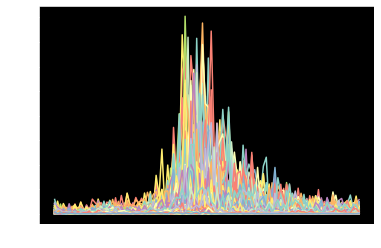

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 106, 1)]          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 106, 32)           320       
_________________________________________________________________
activation_47 (Activation)   (None, 106, 32)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 106, 32)           6176      
_________________________________________________________________
activation_48 (Activation)   (None, 106, 32)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 106, 32)           3104      
_________________________________________________________________
activation_49 (Activation)   (None, 106, 32)           0   

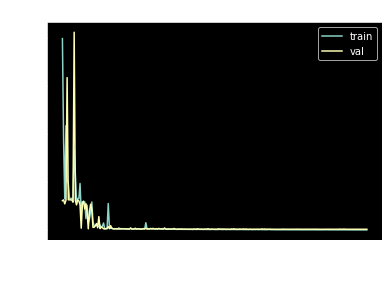

171/1 - 0s - loss: 0.0057 - mean_squared_error: 0.0078
Test Results :  [0.008334156109444928, 0.0077623134]
MSE :  5.504627
Diff Min =  -5.7643291473388665  Max =  6.10432586669922


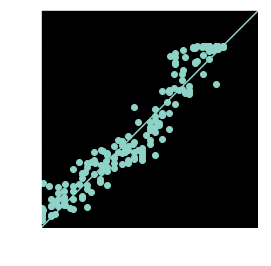

In [32]:
# Select the model's type
MODEL_SELECTED = 'CNN' # 'DNN', 'CNN', 'CNN_PARA', 'CNN_SPEAKER'
# Select the features
file = 'C:/Temp/MeasHydroDone/Features/feat_fft_20_150.csv'
#file = 'C:/Temp/MeasHydroDone/Features/feat_fft_50_150_only2.csv'
#file = 'C:/Temp/MeasHydroDone/VarPompe/Features/feat_fft_70_200.csv'
#file = 'C:/Temp/MeasHydroDone/VarPompe/Features/feat_vib_fft_abs.csv'
''' Split of the features and the labels '''
dataset = pd.read_csv(file)
dataset = dataset.drop(dataset.columns[0], axis=1)
train_X, train_y, test_X, test_y = split_dataset_fix(dataset, testsize=0.2)
# Print features
for i in range(len(train_X)):
    plt.plot(train_X[i])
plt.show()
# Select max/min
train_X_n, test_X_n = train_X, test_X
max_train = train_y.max()
min_train = train_y.min()
# Arrange Y labels between 0 and 1
train_y_n = (train_y-min_train) / (max_train - min_train)
test_y_n = (test_y-min_train) / (max_train - min_train)

''' Reshape the features to match NN input shapes'''
if(MODEL_SELECTED != 'DNN'):    # NO RESHAPE WITH DNN MODEL
    train_X_n = train_X.reshape((train_X.shape[0],train_X.shape[1], 1))
    test_X_n = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
    num_classes = len(np.unique(train_y_n))
    
''' Choose nb of epochs and batch size using to train the NN '''
epochs = 1000
batch_size = 70

''' Define callbacks which should be called during the training '''
callbacks = [
    #keras.callbacks.ModelCheckpoint("../best_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]

''' Prepare the model '''
if(MODEL_SELECTED == 'DNN'):
    hidden_layer = [(128,'relu'), (84,'relu'), (32,'relu')]
    model = make_model_DNN(train_X_n.shape[1:], hidden_layer)
elif(MODEL_SELECTED == 'CNN'):
    convolution =  [(32, 9), (32, 6), (32, 3)]#[(32,6),(32,6),(32,6)] #[(8,9),(8,6),(8,3)]
    mlp = [32,32]
    fct='tanh'
    pooling= 'GlobalAverage'  # 'Max', 'Average', 'GlobalMax', 'GlobalAverage'
    model = make_model_CNN(train_X_n.shape[1:], convolution, mlp, fct, pooling)
elif(MODEL_SELECTED == 'CNN_PARA'):
    model = make_model_CNN_para(train_X_n.shape[1:])
elif(MODEL_SELECTED == 'CNN_SPEAKER'):
    model = make_model_CNN_speak(train_X_n.shape[1:], 1)

model.summary()
keras.utils.plot_model(model, show_shapes=True)
model.compile(optimizer=keras.optimizers.RMSprop(), 
              loss="mean_squared_error", 
              metrics=[keras.losses.MeanSquaredError()])
''' Train the model '''
history = model.fit(
    train_X_n,
    train_y_n,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.3,
    #validation_data=(test_X_n, test_y_n),
    verbose=0
)
display_loss(history)

''' Evaluate the model and plot results'''
test_results = model.evaluate(test_X_n, test_y_n, verbose=2)
print("Test Results : ", test_results)

pred = model.predict(test_X_n).flatten()
pred = pred * (max_train - min_train) + min_train
# print("Pred : ", pred)
# print("Test_y : ", train_y)
mse = keras.losses.MeanSquaredError()
print("MSE : ",mse(test_y, pred).numpy())
plotTestPred(test_y, pred)

In [20]:
# Save the model if good enough
model.save('C:\Temp\k2arm\models\cnn_model_tanh_large.h5') 

## PSEUDO GRID SEARCH WITH CNN

171 685
Shape =  (40, 4)
Model : 
    Convolution :  [(32, 3), (32, 3), (32, 3)]
    MLP         :  [16, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.009226624186733487, 0.008265404]
MSE :  6.0940943
Diff Min =  -5.774300003051756  Max =  7.236705017089843


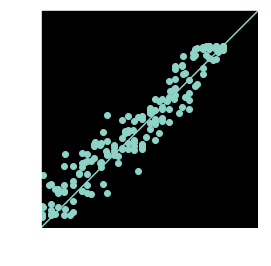



Model : 
    Convolution :  [(32, 3), (32, 3), (32, 3)]
    MLP         :  [32, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.005750815625770878, 0.0051566227]
MSE :  3.7983563
Diff Min =  -5.18573875427246  Max =  6.246770477294923


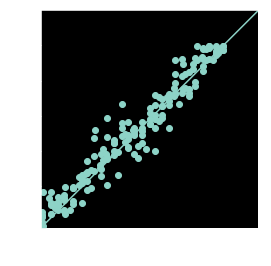



Model : 
    Convolution :  [(32, 3), (32, 3), (32, 3)]
    MLP         :  [64, 64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.009231921489798458, 0.008272493]
MSE :  6.097592
Diff Min =  -5.1514152526855455  Max =  9.118657684326172


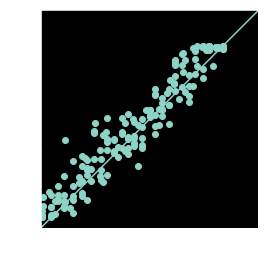



Model : 
    Convolution :  [(32, 3), (32, 3), (32, 3)]
    MLP         :  [64, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.00699132780390601, 0.0062826555]
MSE :  4.617702
Diff Min =  -5.547783660888673  Max =  7.170171356201173


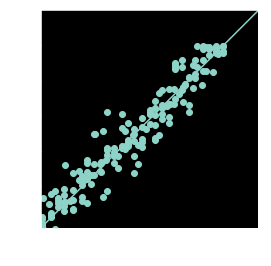



Model : 
    Convolution :  [(32, 3), (32, 3), (32, 3)]
    MLP         :  [32, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.008573363968940474, 0.0076677655]
MSE :  5.6626215
Diff Min =  -6.752670669555663  Max =  5.943803405761718


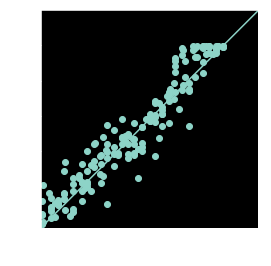



Model : 
    Convolution :  [(32, 3), (32, 3), (32, 3)]
    MLP         :  [16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.014222176635926535, 0.012730122]
MSE :  9.393605
Diff Min =  -7.844304656982423  Max =  11.01743392944336


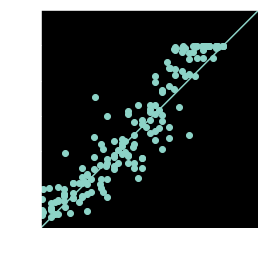



Model : 
    Convolution :  [(32, 3), (32, 3), (32, 3)]
    MLP         :  [32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [2.3576179638243557, 2.5285041]
MSE :  1557.1831
Diff Min =  -51.4  Max =  -25.7


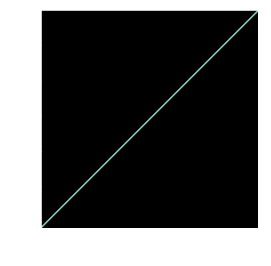



Model : 
    Convolution :  [(32, 3), (32, 3), (32, 3)]
    MLP         :  [64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.011015078678525636, 0.009871774]
MSE :  7.275349
Diff Min =  -7.00276336669922  Max =  8.748326110839844


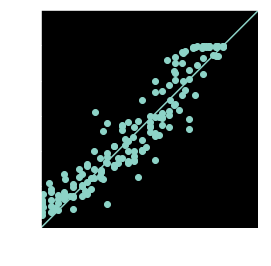



Model : 
    Convolution :  [(32, 6), (32, 6), (32, 6)]
    MLP         :  [16, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.005239633361302447, 0.0047073252]
MSE :  3.4607258
Diff Min =  -5.021658325195311  Max =  4.972201156616212


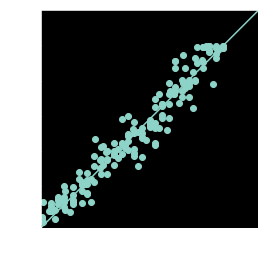



Model : 
    Convolution :  [(32, 6), (32, 6), (32, 6)]
    MLP         :  [32, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.009105360129479134, 0.00816003]
MSE :  6.014001
Diff Min =  -6.573485183715821  Max =  6.3253959655761705


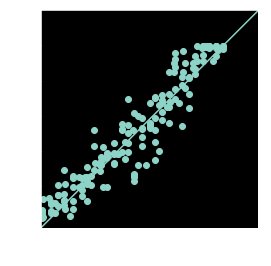



Model : 
    Convolution :  [(32, 6), (32, 6), (32, 6)]
    MLP         :  [64, 64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.004194303656375438, 0.0038123066]
MSE :  2.7702959
Diff Min =  -5.4041923522949205  Max =  5.851207733154297


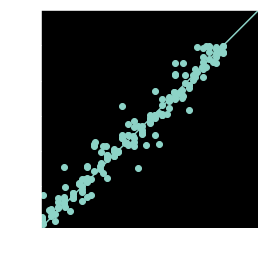



Model : 
    Convolution :  [(32, 6), (32, 6), (32, 6)]
    MLP         :  [64, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.0080519717830718, 0.0072438153]
MSE :  5.3182464
Diff Min =  -6.87656478881836  Max =  6.003691101074217


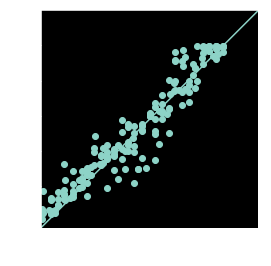



Model : 
    Convolution :  [(32, 6), (32, 6), (32, 6)]
    MLP         :  [32, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.006862414490883592, 0.0061455094]
MSE :  4.5325556
Diff Min =  -6.1944755554199205  Max =  7.5137893676757805


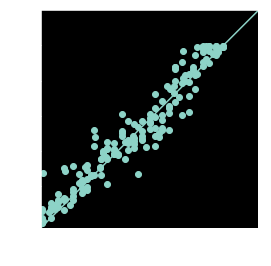



Model : 
    Convolution :  [(32, 6), (32, 6), (32, 6)]
    MLP         :  [16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.3315411145861495, 0.2953506]
MSE :  218.97963
Diff Min =  1.5258789076710855e-06  Max =  25.700001525878907


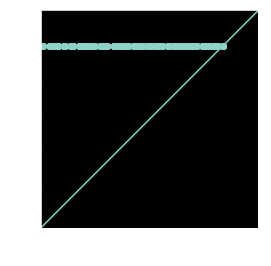



Model : 
    Convolution :  [(32, 6), (32, 6), (32, 6)]
    MLP         :  [32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.006831438588700121, 0.0061365007]
MSE :  4.512098
Diff Min =  -5.586851501464842  Max =  6.0913566589355455


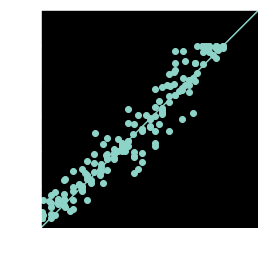



Model : 
    Convolution :  [(32, 6), (32, 6), (32, 6)]
    MLP         :  [64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.01272464898375424, 0.011391577]
MSE :  8.404503
Diff Min =  -6.9446939468383775  Max =  10.452057647705079


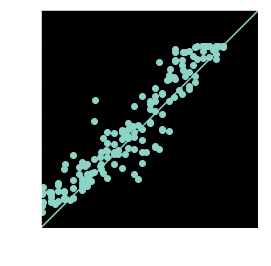



Model : 
    Convolution :  [(32, 9), (32, 9), (32, 9)]
    MLP         :  [16, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.008164821967703143, 0.0073281396]
MSE :  5.392783
Diff Min =  -6.853809738159178  Max =  6.281183624267577


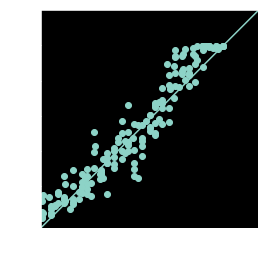



Model : 
    Convolution :  [(32, 9), (32, 9), (32, 9)]
    MLP         :  [32, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.007876860500008347, 0.007049069]
MSE :  5.202588
Diff Min =  -8.084631347656249  Max =  4.784674072265624


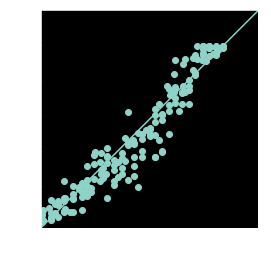



Model : 
    Convolution :  [(32, 9), (32, 9), (32, 9)]
    MLP         :  [64, 64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.006204190581617605, 0.0055947616]
MSE :  4.097806
Diff Min =  -5.7929910659790025  Max =  4.977393341064452


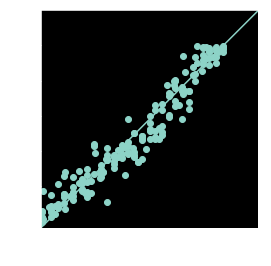



Model : 
    Convolution :  [(32, 9), (32, 9), (32, 9)]
    MLP         :  [64, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.006994839589865824, 0.006290959]
MSE :  4.6200223
Diff Min =  -8.426707077026368  Max =  4.068447875976563


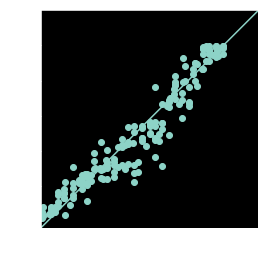



Model : 
    Convolution :  [(32, 9), (32, 9), (32, 9)]
    MLP         :  [32, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.007242274802172698, 0.0065123383]
MSE :  4.78345
Diff Min =  -5.28664665222168  Max =  5.565480041503907


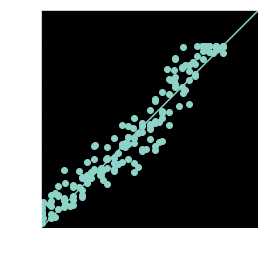



Model : 
    Convolution :  [(32, 9), (32, 9), (32, 9)]
    MLP         :  [16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.006539783446317026, 0.0058703707]
MSE :  4.3194613
Diff Min =  -7.048980140686034  Max =  4.852320098876952


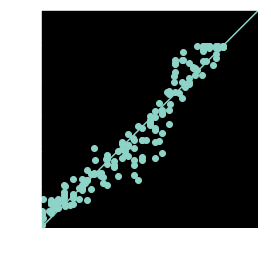



Model : 
    Convolution :  [(32, 9), (32, 9), (32, 9)]
    MLP         :  [32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.008979551047352225, 0.008030639]
MSE :  5.9309044
Diff Min =  -9.236935424804688  Max =  5.594240570068358


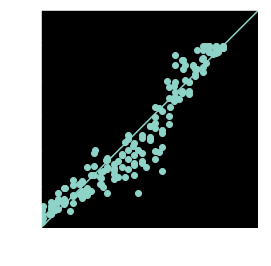



Model : 
    Convolution :  [(32, 9), (32, 9), (32, 9)]
    MLP         :  [64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.008501441070567599, 0.007618156]
MSE :  5.6151166
Diff Min =  -7.593468093872069  Max =  5.854100799560548


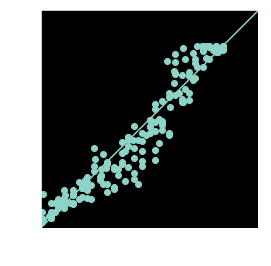



Model : 
    Convolution :  [(32, 9), (32, 6), (32, 3)]
    MLP         :  [16, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.007798559917409343, 0.006997554]
MSE :  5.1508703
Diff Min =  -9.577952575683593  Max =  5.628054046630858


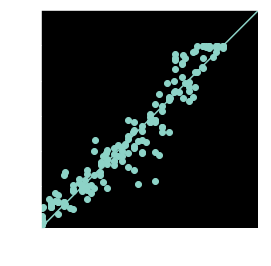



Model : 
    Convolution :  [(32, 9), (32, 6), (32, 3)]
    MLP         :  [32, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.009488240312934684, 0.00851032]
MSE :  6.2668886
Diff Min =  -6.665609741210936  Max =  6.1098503112792955


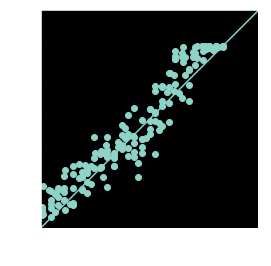



Model : 
    Convolution :  [(32, 9), (32, 6), (32, 3)]
    MLP         :  [64, 64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.005214259154381154, 0.004719091]
MSE :  3.4439666
Diff Min =  -5.131754302978514  Max =  6.275115585327148


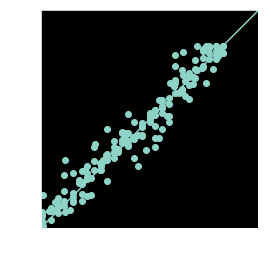



Model : 
    Convolution :  [(32, 9), (32, 6), (32, 3)]
    MLP         :  [64, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.005200208103820703, 0.0046889856]
MSE :  3.4346852
Diff Min =  -6.485433959960936  Max =  5.9430801391601555


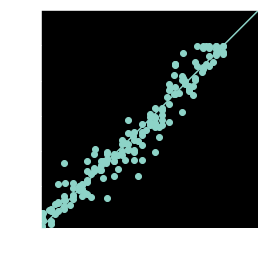



Model : 
    Convolution :  [(32, 9), (32, 6), (32, 3)]
    MLP         :  [32, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.008355787130786182, 0.0075925025]
MSE :  5.5189147
Diff Min =  -7.807803344726562  Max =  6.173559570312499


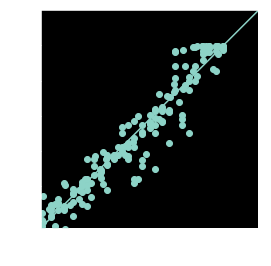



Model : 
    Convolution :  [(32, 9), (32, 6), (32, 3)]
    MLP         :  [16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.008802821342315938, 0.00793088]
MSE :  5.814175
Diff Min =  -8.26231689453125  Max =  6.370367431640624


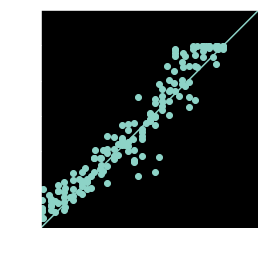



Model : 
    Convolution :  [(32, 9), (32, 6), (32, 3)]
    MLP         :  [32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.006281270531356084, 0.005643587]
MSE :  4.1487164
Diff Min =  -5.393433761596679  Max =  6.473412704467773


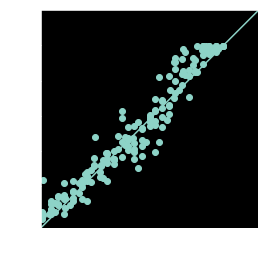



Model : 
    Convolution :  [(32, 9), (32, 6), (32, 3)]
    MLP         :  [64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.008603686477195156, 0.007713785]
MSE :  5.682649
Diff Min =  -8.320923233032225  Max =  6.724604415893555


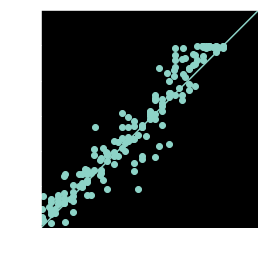



Model : 
    Convolution :  [(32, 3), (32, 6), (32, 9)]
    MLP         :  [16, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.006543682444955043, 0.005886156]
MSE :  4.3220363
Diff Min =  -5.783243942260743  Max =  5.409661483764648


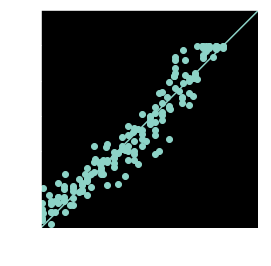



Model : 
    Convolution :  [(32, 3), (32, 6), (32, 9)]
    MLP         :  [32, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.007016032796668989, 0.006326984]
MSE :  4.6340194
Diff Min =  -5.878179931640624  Max =  5.549191284179688


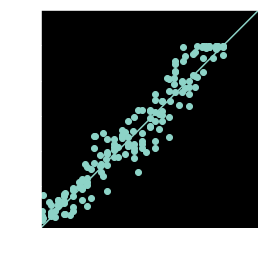



Model : 
    Convolution :  [(32, 3), (32, 6), (32, 9)]
    MLP         :  [64, 64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.0052137134970459895, 0.004697366]
MSE :  3.4436057
Diff Min =  -6.1485466003417955  Max =  6.460642242431639


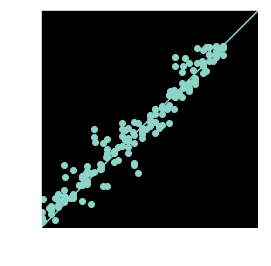



Model : 
    Convolution :  [(32, 3), (32, 6), (32, 9)]
    MLP         :  [64, 32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.00676330746960287, 0.00607769]
MSE :  4.4670973
Diff Min =  -8.815674209594725  Max =  5.836586380004881


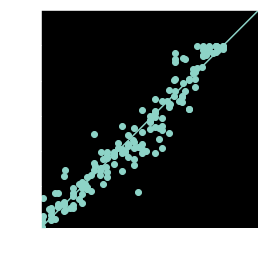



Model : 
    Convolution :  [(32, 3), (32, 6), (32, 9)]
    MLP         :  [32, 16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.00675080226099783, 0.006051943]
MSE :  4.4588375
Diff Min =  -7.308085823059081  Max =  6.8435111999511715


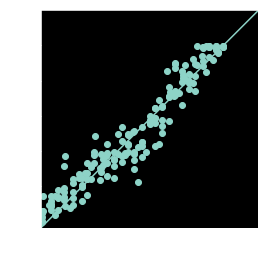



Model : 
    Convolution :  [(32, 3), (32, 6), (32, 9)]
    MLP         :  [16]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.008903288999667707, 0.007994206]
MSE :  5.880533
Diff Min =  -7.557505035400389  Max =  5.941801452636717


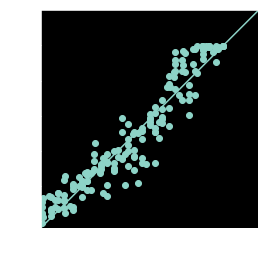



Model : 
    Convolution :  [(32, 3), (32, 6), (32, 9)]
    MLP         :  [32]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.009667424666858687, 0.008666771]
MSE :  6.3852377
Diff Min =  -9.344229888916015  Max =  7.771483230590821


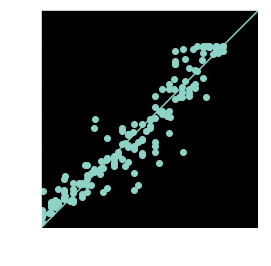



Model : 
    Convolution :  [(32, 3), (32, 6), (32, 9)]
    MLP         :  [64]
    Fct         :  tanh
    Pool        :  GlobalAverage

Test Results :  [0.011596101152367498, 0.01038741]
MSE :  7.659109
Diff Min =  -7.456657791137694  Max =  6.605467224121092


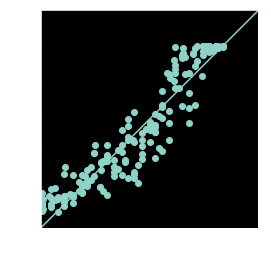



FINAL RESULT : 
Best Error :  1
Best Diff  :  [-3.36812763e+00 -2.50759773e+00 -1.74257545e+00 -3.45671730e+00
 -1.64131813e+00 -2.77111359e+00 -5.49143333e+00 -4.39559021e+00
 -1.44105778e+00 -1.33318481e+00 -4.16261063e+00 -1.45421181e+00
 -1.69740829e+00 -1.02223206e+00 -5.21294022e+00 -1.90318642e+00
 -2.16863022e+00 -2.22240791e+00 -2.94251404e+00 -8.13487244e-01
 -1.39324970e+00 -4.30825424e-01 -1.80398102e+00 -3.02472801e+00
 -2.94479332e+00 -7.07126236e-01  7.00948906e-01 -2.91506195e-01
  1.89706421e-01  1.79797745e-01 -3.25595512e+00 -5.53778076e-01
  1.06157722e+00 -5.55953979e-03 -5.32136154e-01  1.79784088e+00
 -2.74792786e+00  6.52170944e-01 -1.47905083e+00 -1.38543434e+00
 -3.78448486e-01  9.76274490e-01 -3.37923050e-01 -1.12464905e+00
  7.77261734e-01  7.14516830e-01  2.51592827e-01 -4.31639328e+00
 -5.98301315e-01 -2.58128967e+00 -4.93043213e+00  2.72319832e+00
 -2.59447632e+00  1.43817673e+00  3.47833252e-01  2.83383236e+00
 -6.06408234e+00  2.93018322e+00 -1.601233

In [35]:
''' Normalisation of the features and the labels '''
file = 'C:/Temp/MeasHydroDone/Features/feat_fft_20_150.csv'
dataset = pd.read_csv(file)
dataset = dataset.drop(dataset.columns[0], axis=1)
train_X, train_y, test_X, test_y = split_dataset_fix(dataset, testsize=0.2)

#train_X_n, test_X_n = scale_features(train_X, test_X)
train_X_n, test_X_n = train_X, test_X
max_train = train_y.max()
min_train = train_y.min()
train_y_n = (train_y-min_train) / (max_train - min_train)
test_y_n = (test_y-min_train) / (max_train - min_train)

''' Reshape the features to match NN input shapes'''
train_X_n = train_X.reshape((train_X_n.shape[0],train_X_n.shape[1], 1))
test_X_n = test_X.reshape((test_X_n.shape[0], test_X_n.shape[1], 1))
num_classes = len(np.unique(train_y_n))

''' Choose nb of epochs and batch size using to train the NN '''
epochs = 1000
batch_size = 70

''' Define callbacks which should be called during the training '''
callbacks = [
    #keras.callbacks.ModelCheckpoint("../best_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=0),
]

''' Prepare combination '''
conv = [[(32,3),(32,3),(32,3)],
        [(32,6),(32,6),(32,6)],
        [(32,9),(32,9),(32,9)],
        [(32,9),(32,6),(32,3)],
        [(32,3),(32,6),(32,9)]]
# conv = [[(3,6),(3,6),(3,6)],
#         [(6,6),(6,6),(6,6)],
#         [(9,6),(9,6),(9,6)],
#         [(3,3),(3,6),(3,9)],
#         [(6,3),(6,6),(6,9)],
#         [(9,3),(9,6),(9,9)],]
mlp = [[16,16],
       [32,32],
       [64,64],
       [64,32],
       [32,16],
       [16],
       [32],
       [64]]
fct = ['tanh']
pool = ['GlobalAverage'] 

grid = pd.DataFrame(list(product(conv, mlp, fct, pool)), columns=['Conv', 'MLP', 'Fct', 'Pool'])
print("Shape = ", grid.shape)

''' Search the best result'''
best_diff = []
best_error = 100
best_model = grid.loc[0]
for index, row in grid.iterrows():
    print("Model : ")
    print("    Convolution : ", row['Conv'])
    print("    MLP         : ", row['MLP'])
    print("    Fct         : ", row['Fct'])
    print("    Pool        : ", row['Pool'])
    print()
    ''' Prepare the model'''
    model = make_model_CNN(train_X_n.shape[1:], row['Conv'], row['MLP'], row['Fct'], row['Pool'])
    model.compile(optimizer=keras.optimizers.RMSprop(), 
                  loss="mean_squared_error", 
                  metrics=[keras.losses.MeanSquaredError()])
    ''' Train the model '''
    history = model.fit(
        train_X_n,
        train_y_n,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        validation_split=0.3,
        verbose=0,
        use_multiprocessing=True,
    )
    ''' Evaluate the model and plot results'''
    test_results = model.evaluate(test_X_n, test_y_n,verbose=0)
    print("Test Results : ", test_results)
    pred = model.predict(test_X_n).flatten()
    pred = pred * (max_train - min_train) + min_train
    mse = keras.losses.MeanSquaredError()
    res_mse = mse(test_y, pred).numpy()
    print("MSE : ",res_mse)
    plotTestPred(test_y, pred)
    print()
    print()
    if(res_mse < best_error):
        best_error = res_mse
        best_diff = diff
        best_model = row

''' Display Final Result'''
print("FINAL RESULT : ")
print("Best Error : ", best_error)
print("Best Diff  : ", diff)
print("Best Model :")
print("    Convolution : ", best_model['Conv'])
print("    MLP         : ", best_model['MLP'])
print("    Fct         : ", best_model['Fct'])
print("    Pooling     : ", best_model['Pool'])

## BEST RESULTS

Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 106, 1)]          0         
_________________________________________________________________
conv1d_171 (Conv1D)          (None, 106, 32)           320       
_________________________________________________________________
activation_326 (Activation)  (None, 106, 32)           0         
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 106, 32)           6176      
_________________________________________________________________
activation_327 (Activation)  (None, 106, 32)           0         
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 106, 32)           3104      
_________________________________________________________________
activation_328 (Activation)  (None, 106, 32)           0  

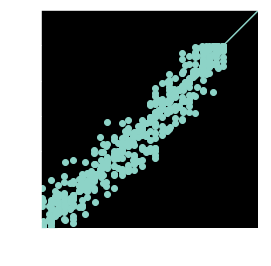

In [46]:
'''
    Display the whole dataset's prediction
'''
model_ref_path = 'C:\Temp\k2arm\models\cnn_model_tanh_large.h5'
model_ref = keras.models.load_model(model_ref_path, compile=False)
model_ref.summary()
file = 'C:/Temp/MeasHydroDone/Features/feat_fft_20_150.csv'
dataset = pd.read_csv(file)
dataset = dataset.drop(dataset.columns[0], axis=1)
y_data = dataset['FlowRate'].astype(float).to_numpy()
x_data = dataset.drop(['FlowRate'], axis=1).to_numpy()
max_train = y_data.max()
min_train = y_data.min()
x_data_n = x_data.reshape((x_data.shape[0],x_data.shape[1], 1))
y_data_n = (y_data-min_train) / (max_train - min_train)

pred = model_ref.predict(x_data_n).flatten()
pred = pred * (max_train - min_train) + min_train
mse = keras.losses.MeanSquaredError()
res_mse = mse(y_data, pred).numpy()
print("MSE : ",res_mse)
plotTestPred(y_data, pred)